In [14]:
import torch
import tiktoken
from GPT2Model import GPTModel, generate_text_simple, create_dataloader,text_to_token_ids,token_ids_to_text
from GPT2Model import calc_loss_batch,calc_loss_loader
from GPT2Model import evaluate_model, generate_and_print_sample, generate_text
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, 
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=False)
        (Wk): Linear(in_features=768, out_features=768, bias=False)
        (Wv): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features

In [3]:
with open("The-Verdict.txt", "r", encoding="utf-8") as f:
    text_data = f.read()
    
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [4]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
 train_data,
 batch_size=4,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)
val_loader = create_dataloader(
 val_data,
 batch_size=4,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)


print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [5]:
# Learning rate warmup

n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01


total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

12


In [8]:

model.to(device) 
with torch.no_grad(): 
 train_loss = calc_loss_loader(train_loader, model, device) 
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss model not trained:", train_loss)
print("Validation loss model not trained:", val_loss)

Training loss model not trained: 10.986347675323486
Validation loss model not trained: 10.98110580444336


In [34]:
ORIG_BOOK_VERSION = False

def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if ORIG_BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            else:
                if global_step >= warmup_steps:  # the book originally used global_step > warmup_steps, which lead to a skipped clipping step after warmup
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        '''
        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        '''
    return train_losses, val_losses, track_tokens_seen, track_lrs

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.968, Val loss 10.936
Ep 1 (Iter 000005): Train loss 8.850, Val loss 8.971
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 6.408, Val loss 6.971
Ep 2 (Iter 000015): Train loss 6.034, Val loss 6.800
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.575, Val loss 7.758
Ep 3 (Iter 000025): Train loss 5.425, Val loss 6.876
Every effort moves you, the,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 4 (Iter 000030): Train loss 5.858, Val loss 7.170
Ep 4 (Iter 000035): Train loss 5.819, Val loss 7.000
Every effort moves you, and, and, and, and, and the, and, and, and, and, and, and, and, and, and the, and the, and, and, and, and the, and the, and, and the
Ep 5 (Iter 000040): Train loss 4.358, Val loss 6.626
Every effort moves you.  "I had been, and I had been the picture.                                   
Ep 6 (Iter 000045): Train loss 4.198, 

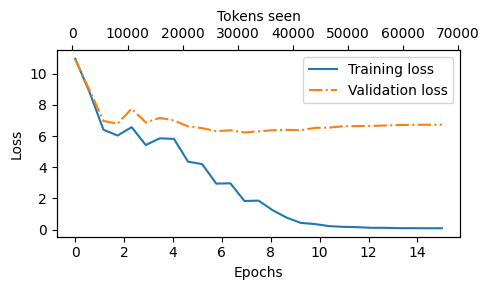

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

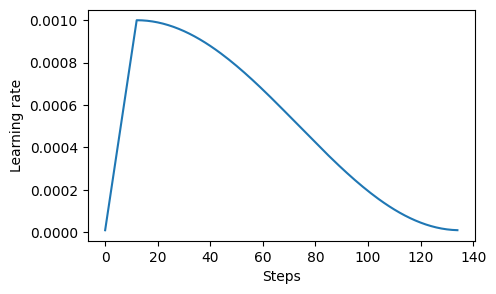

In [31]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

### Hyperparameter tunning

In [32]:

# Define a grid of hyperparameters to search over
HPARAM_GRID = {
    "batch_size": [2, 4, 8],
    "drop_rate": [0.1, 0.2],
    "warmup_steps": [10, 20],
    "weight_decay": [0.1, 0.01, 0.0],
    "peak_lr": [0.0001, 0.0005, 0.001, 0.005],
    "initial_lr": [0.0001, 0.0002],
    "min_lr": [0.00005, 0.00001, 0.0001],
    "n_epochs": [5, 10],
}

In [35]:
import itertools
# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(*HPARAM_GRID.values()))
total_combinations = len(hyperparameter_combinations)
print(f"Total hyperparameter configurations: {total_combinations}")
# Placeholder for the best loss and best hyperparameters
best_val_loss = float('inf')
best_hparams = {}

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
interrupted = False
current_config = 0
for combination in hyperparameter_combinations:

    try:
        current_config += 1
        print(f"Evaluating configuration {current_config} of {total_combinations}")

        # Unpack the current combination of hyperparameters
        HPARAM_CONFIG = dict(zip(HPARAM_GRID.keys(), combination))

        GPT_CONFIG_124M = {
            "vocab_size": 50257,    # Vocabulary size
            "context_length": 256,  # Context length -- shortened from original 1024 tokens
            "emb_dim": 768,         # Embedding dimension
            "n_heads": 12,          # Number of attention heads
            "n_layers": 12,         # Number of layers
            "drop_rate": HPARAM_CONFIG["drop_rate"],
            "qkv_bias": False,     # Query-Key-Value bias
        }

        torch.manual_seed(123)
        train_loader = create_dataloader(
            text_data[:split_idx],
            batch_size=HPARAM_CONFIG["batch_size"],
            max_length=GPT_CONFIG_124M["context_length"],
            stride=GPT_CONFIG_124M["context_length"],
            drop_last=True,
            shuffle=True,
            num_workers=0
        )

        val_loader = create_dataloader(
            text_data[split_idx:],
            batch_size=HPARAM_CONFIG["batch_size"],
            max_length=GPT_CONFIG_124M["context_length"],
            stride=GPT_CONFIG_124M["context_length"],
            drop_last=False,
            shuffle=False,
            num_workers=0
        )

        model = GPTModel(GPT_CONFIG_124M)
        model.to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=HPARAM_CONFIG["peak_lr"],
            weight_decay=HPARAM_CONFIG["weight_decay"]
        )

        encoded_start_context = tokenizer.encode("Nevertheless")
        encoded_tensor = torch.tensor(encoded_start_context).unsqueeze(0)

        train_loss, val_loss = train_model(
            model, train_loader, val_loader, optimizer, device,
            n_epochs=HPARAM_CONFIG["n_epochs"],
            eval_freq=5, eval_iter=1,
            start_context=encoded_tensor,
            tokenizer=tokenizer,
            warmup_steps=HPARAM_CONFIG["warmup_steps"],
            initial_lr=HPARAM_CONFIG["initial_lr"],
            min_lr=HPARAM_CONFIG["min_lr"]
        )

        # Log the best hyperparameters based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = train_loss
            best_hparams = HPARAM_CONFIG
    except KeyboardInterrupt:
        print("Hyperparameter search completed.")
        print(f"Best hyperparameters: {best_hparams}")
        print(f"Best Val loss: {best_val_loss} | Training loss {train_loss}")
        interrupted = True
        break
if not interrupted:
    print("Hyperparameter search completed.")
    print(f"Best hyperparameters: {best_hparams}")
    print(f"Best Val loss: {best_val_loss} | Training loss {train_loss}")

Total hyperparameter configurations: 1728
Evaluating configuration 1 of 1728
Ep 1 (Iter 000000): Train loss 10.515, Val loss 10.574
Ep 1 (Iter 000005): Train loss 9.207, Val loss 9.413
Ep 2 (Iter 000010): Train loss 8.687, Val loss 8.885
Ep 2 (Iter 000015): Train loss 8.486, Val loss 8.496
Ep 3 (Iter 000020): Train loss 7.898, Val loss 8.168
Ep 3 (Iter 000025): Train loss 7.357, Val loss 7.887
Ep 4 (Iter 000030): Train loss 7.424, Val loss 7.657
Ep 4 (Iter 000035): Train loss 6.766, Val loss 7.474
Ep 5 (Iter 000040): Train loss 6.923, Val loss 7.331


ValueError: too many values to unpack (expected 2)